# ---START---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tools.eval_measures import rmspe, rmse, aic
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import kpss, adfuller
from itertools import product
import statsmodels as sm
from pathlib import Path


warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [10, 3]

In [2]:
sm.__version__

'0.13.1'

In [3]:
msft_file = Path('../../datasets/Ch10/msft.csv')
life_file = Path('../../datasets/Ch10/life_expectancy_birth.csv')
milk_file = Path('../../datasets/Ch10/milk_production.csv')

msft = pd.read_csv(msft_file, index_col='Date', 
                   parse_dates=True)

life = pd.read_csv(life_file, 
                   index_col='year',
                   parse_dates=True,
                  skipfooter=1)

milk = pd.read_csv(milk_file, 
                   index_col='month', 
                   parse_dates=True)

In [4]:
life.shape

(59, 1)

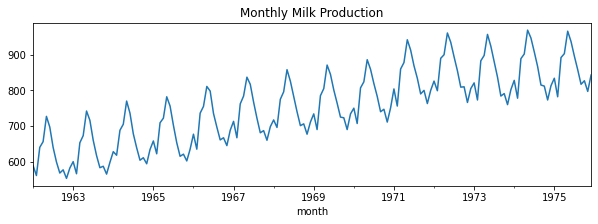

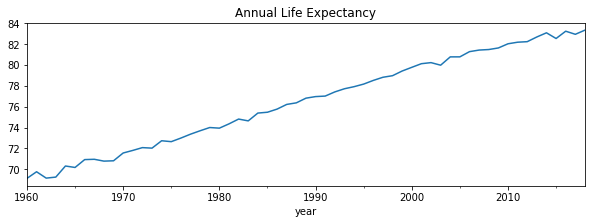

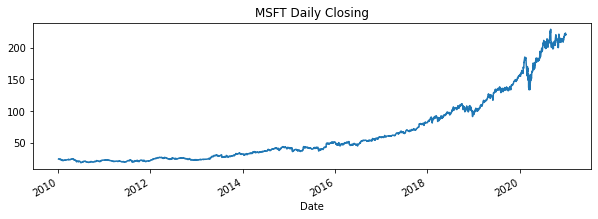

In [5]:
milk.plot(title='Monthly Milk Production', 
                        legend=False)
life.plot(title='Annual Life Expectancy', 
                        legend=False)
msft.plot(title='MSFT Daily Closing', 
                        legend=False)
plt.show()

In [6]:
def split_data(df, test_split):
    # l = df.shape[0]
    l = len(df)
    t_idx = l - round(l*test_split)
    if type(df) == pd.DataFrame:
        train = df.iloc[ : t_idx]
        test = df.iloc[t_idx : ]
    else:
        train = df[:t_idx]
        test = df[t_idx:]

    print(f'train: {len(train)} , test: {len(test)}')
    return train, test

In [7]:
test_split = 0.15
milk_train, milk_test = split_data(milk, test_split)
life_train, life_test = split_data(life, test_split)
msft_train, msft_test = split_data(msft, test_split)

train: 143 , test: 25
train: 50 , test: 9
train: 2354 , test: 415


In [8]:
def check_stationarity(df, r='c'):
    results = adfuller(df, regression=r)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{r}'\t {s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

In [9]:
def get_best_model(score, c='AIC'):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score = v[c]
            best_model = k
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']

In [10]:
def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]), 
                            index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()

In [11]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]
    return combo

# Plotting ACF and PACF

<AxesSubplot:xlabel='year'>

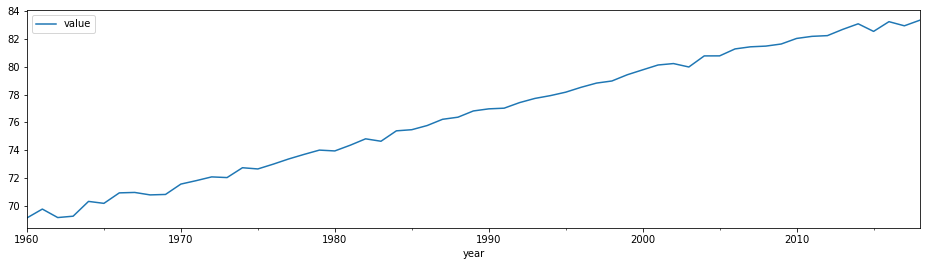

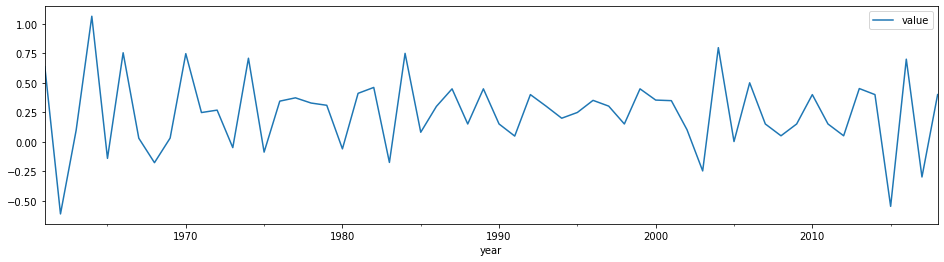

In [12]:
plt.rcParams["figure.figsize"] = [16, 4]
life.plot()
life_diff = life.diff().dropna()
life_diff.plot()

In [13]:
adfuller(life_diff)

(-8.852827785616508,
 1.5562189676003248e-14,
 1,
 56,
 {'1%': -3.552928203580539,
  '5%': -2.9147306250000002,
  '10%': -2.595137155612245},
 -8.125745778440447)

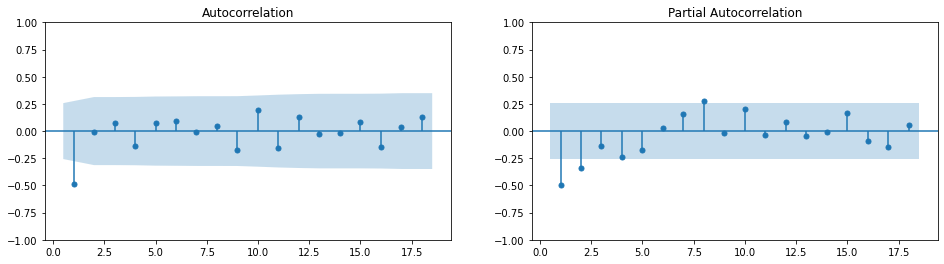

In [14]:
fig, ax = plt.subplots(1,2)
plot_acf(life_diff, zero=False, ax=ax[0])
plot_pacf(life_diff, zero=False, ax=ax[1]);plt.show()

<AxesSubplot:xlabel='month'>

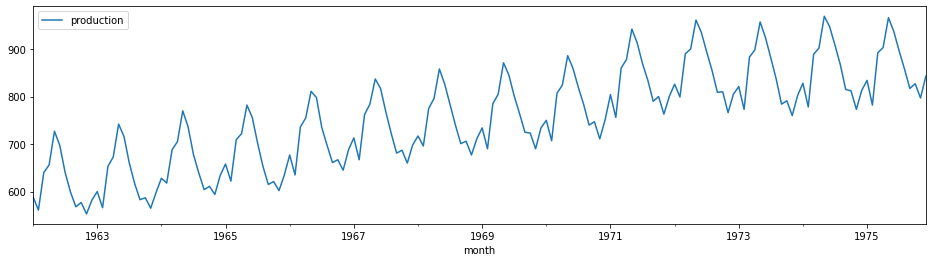

In [15]:
milk.plot()

In [16]:
milk_diff_12 = milk.diff(12).dropna()

In [17]:
check_stationarity(milk_diff_12)

'c'	 Non-Stationary	 p-value:0.16079880527711382 	 lags:12


('Non-Stationary', 0.16079880527711382)

In [18]:
milk_diff_12_1 = milk.diff(12).diff(1).dropna()
check_stationarity(milk_diff_12_1)

'c'	 Stationary	 p-value:1.865423431878876e-05 	 lags:11


('Stationary', 1.865423431878876e-05)

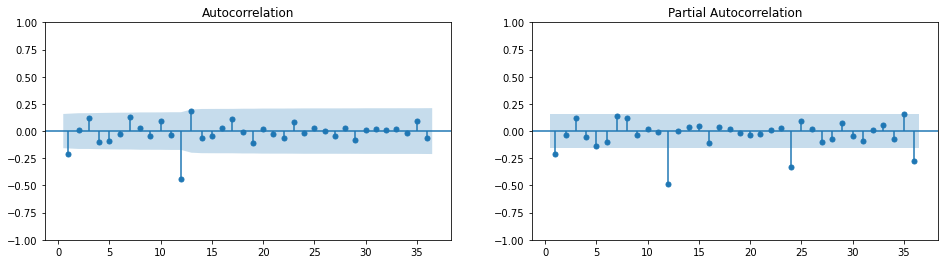

In [19]:
fig, ax = plt.subplots(1,2)
plot_acf(milk_diff_12_1, zero=False, ax=ax[0], lags=36)
plot_pacf(milk_diff_12_1, zero=False, ax=ax[1], lags=36);plt.show()

### There is more

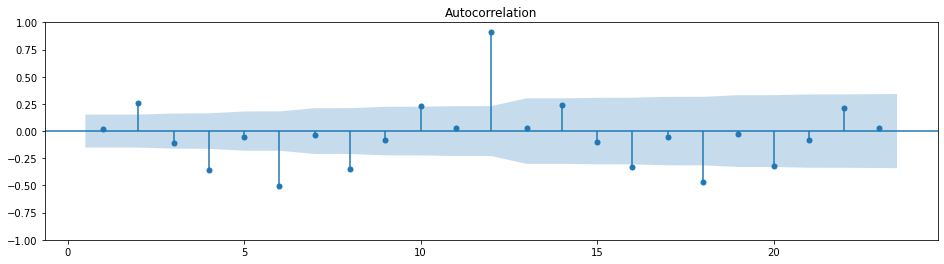

In [59]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(milk, order=(0,1,0),
                easonal_order=(0,0,0, 12)).fit(disp=False)
plot_acf(model.resid[1:], zero=False);plt.show()

<AxesSubplot:xlabel='month'>

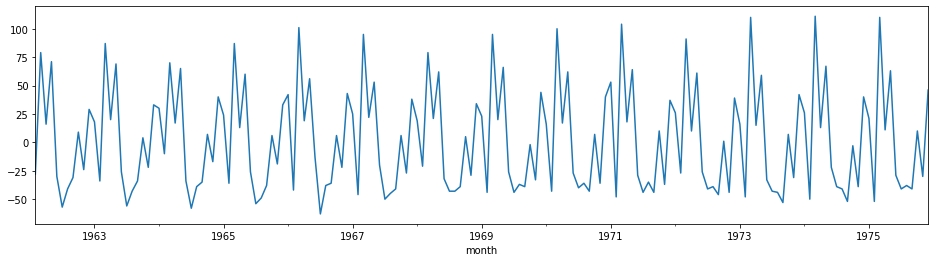

In [60]:
model.resid[1:].plot()

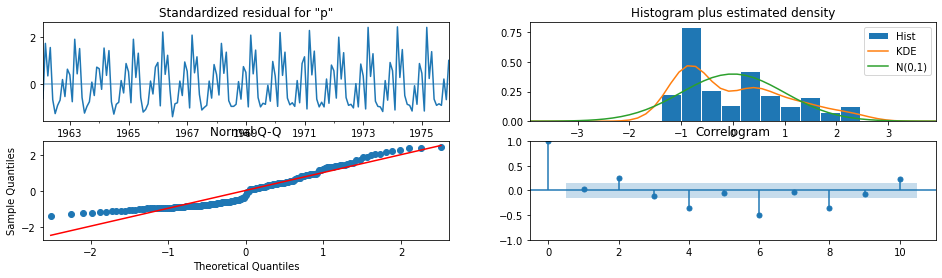

In [61]:
model.plot_diagnostics();

In [62]:
model.resid[1:]

month
1962-02-01   -28.0
1962-03-01    79.0
1962-04-01    16.0
1962-05-01    71.0
1962-06-01   -30.0
              ... 
1975-08-01   -38.0
1975-09-01   -41.0
1975-10-01    10.0
1975-11-01   -30.0
1975-12-01    46.0
Length: 167, dtype: float64

# Forecasting Univariate Time Series Data with Exponential Smoothing

In [12]:
from statsmodels.tsa.api import ExponentialSmoothing

In [13]:
trend = ['add', 'mul']
damped = [True, False]
life_ex_comb = combinator([trend, damped])
life_ex_comb

[('add', True), ('add', False), ('mul', True), ('mul', False)]

In [14]:
score = {}
for i, (t, dp) in enumerate(life_ex_comb):
    data = life_train.values.ravel()
    y = life_test.values.ravel()
    exp = ExponentialSmoothing(data, 
                     trend=t, 
                     damped_trend=dp,
                     seasonal=None).fit(use_brute=True,
                                       optimized=True)
    
    y_hat = exp.forecast(len(y))
    score[i] = {'trend':t,
                'damped':dp,
                'AIC':exp.aic,
                'BIC':exp.bic, 
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
               'model': exp}

In [15]:
life_best_model = get_best_model(score, 'AIC')

Best model: 1 with lowest AIC score: -137.03060180140557


In [16]:
life_best_model.summary()

Dep. Variable:,endog,No. Observations:,50
Model:,ExponentialSmoothing,SSE,2.749
Optimized:,True,AIC,-137.031
Trend:,Additive,BIC,-129.383
Seasonal:,None,AICC,-135.077
Seasonal Periods:,None,Date:,"Tue, 11 Jan 2022"
Box-Cox:,False,Time:,23:03:47
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1621952,alpha,True
smoothing_trend,0.1621952,beta,True


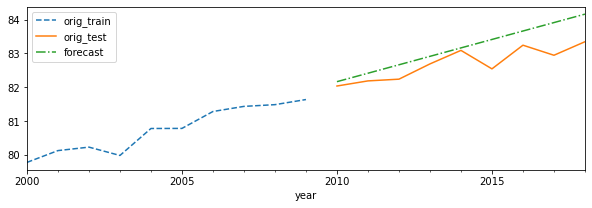

In [302]:
plot_forecast(life_best_model, '2000', life_train, life_test)

In [339]:
def hw_models(combos, train, test):
    train = train.values.ravel()
    test = test.values.ravel()
    score = {}
    for i, (t, dp, s, sp) in enumerate(combos):
        exp = ExponentialSmoothing(train, 
                         trend=t, 
                         damped_trend=dp,
                         seasonal=s,
                         seasonal_periods=sp).fit(use_brute=True,
                                           optimized=True)
            
    
        y_hat = exp.forecast(len(test))
        score[i] = {'trend':t,
                    'damped':dp,
                    'AIC':exp.aic,
                    'BIC':exp.bic, 
                    'RMSPE': rmspe(test, y_hat),
                    'RMSE' : rmse(test, y_hat),
                    # 'MAPE' : mape(test, y_hat),
                    'model': exp}
        
    return score

In [332]:
trend = ['add', 'mul']
damped = [True, False]
seasonal = ['add' , 'mul']
periods = [22, 66,252]
msft_exp_comb = combinator([trend, damped, seasonal, periods])

In [333]:
msft_scores = hw_models(msft_exp_comb, msft_train, msft_test)
msft_model = get_best_model(msft_scores)

Best model: 6 with lowest AIC score: -1139.512881048595


In [335]:
msft_model.summary()

Dep. Variable:,endog,No. Observations:,2354
Model:,ExponentialSmoothing,SSE,1418.998
Optimized:,True,AIC,-1139.513
Trend:,Additive,BIC,-989.652
Seasonal:,Additive,AICC,-1138.814
Seasonal Periods:,22,Date:,"Thu, 23 Dec 2021"
Box-Cox:,False,Time:,17:42:14
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8697584,alpha,True
smoothing_trend,0.0019371,beta,True


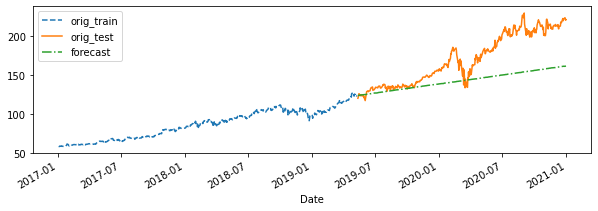

In [336]:
plot_forecast(msft_model, '2017', msft_train, msft_test)

In [340]:
trend = ['add', 'mul']
damped = [True, False]
seasonal = ['add' , 'mul']
periods = [4, 6, 12]
milk_exp_comb = combinator([trend, damped, seasonal, periods])

milk_scores = hw_models(milk_exp_comb, milk_train, milk_test)
milk_model = get_best_model(milk_scores)

Best model: 8 with lowest AIC score: 593.7138857685106


In [341]:
milk_model.summary()

Dep. Variable:,endog,No. Observations:,143
Model:,ExponentialSmoothing,SSE,7265.655
Optimized:,True,AIC,593.714
Trend:,Additive,BIC,641.119
Seasonal:,Additive,AICC,599.230
Seasonal Periods:,12,Date:,"Thu, 23 Dec 2021"
Box-Cox:,False,Time:,17:45:08
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6859108,alpha,True
smoothing_trend,0.000000,beta,True


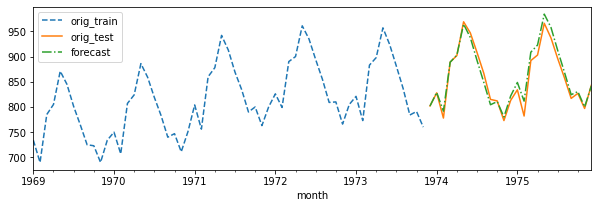

In [344]:
plot_forecast(milk_model, '1969', milk_train, milk_test)

## There is more

In [345]:
from darts.models import ExponentialSmoothing
from darts import TimeSeries

Importing plotly failed. Interactive plots will not work.


In [346]:
model = ExponentialSmoothing(seasonal_periods=12)
ts = TimeSeries.from_dataframe(milk.reset_index(), 
                                    time_col='month', value_cols='production', freq='MS')
train, test = split_data(ts, 0.15)

train: 143 , test: 25


In [347]:
model.fit(train)
forecast = model.predict(len(test), num_samples=100)

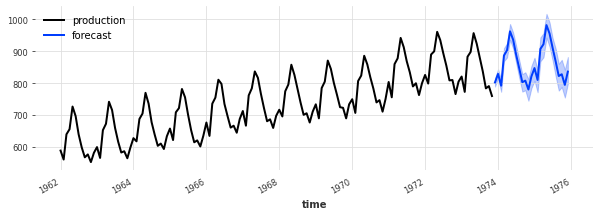

In [348]:
train.plot()
forecast.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)

In [349]:
model.model.summary()

Dep. Variable:,endog,No. Observations:,143
Model:,ExponentialSmoothing,SSE,7265.655
Optimized:,True,AIC,593.714
Trend:,Additive,BIC,641.119
Seasonal:,Additive,AICC,599.230
Seasonal Periods:,12,Date:,"Thu, 23 Dec 2021"
Box-Cox:,False,Time:,17:47:05
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6859108,alpha,True
smoothing_trend,0.000000,beta,True


# Non-Seasonal ARIMA

In [63]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

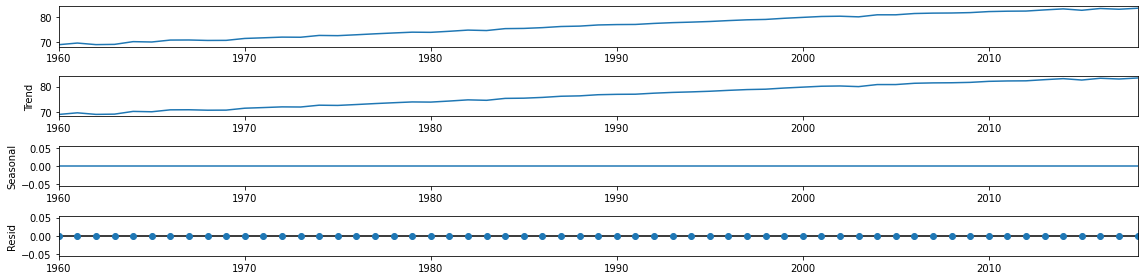

In [64]:
decomposed = seasonal_decompose(life)
decomposed.plot(); plt.show()

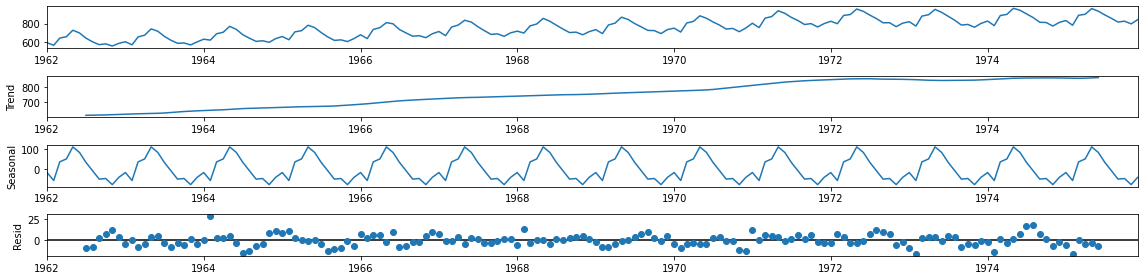

In [65]:
decomposed = seasonal_decompose(milk, period=12)
decomposed.plot(); plt.show()

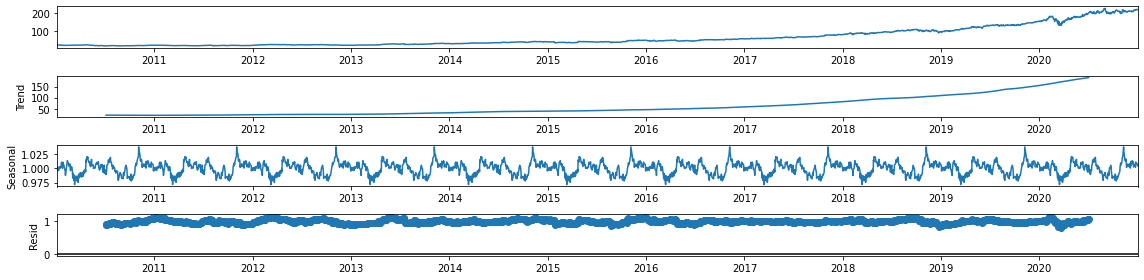

In [66]:
decomposed = seasonal_decompose(msft, period=252, model='multiplicative')
decomposed.plot(); plt.show()

In [67]:
from pandas.plotting import autocorrelation_plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

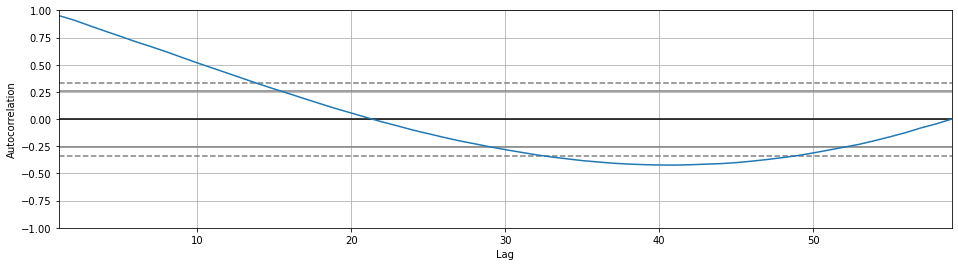

In [68]:
autocorrelation_plot(life)

In [69]:
outputs = []
for r in ['c', 'ct', 'ctt', 'nc']:
    check_stationarity(life, r)

'c'	 Non-Stationary	 p-value:0.6420882853800043 	 lags:2
'ct'	 Non-Stationary	 p-value:0.9969227873532553 	 lags:4
'ctt'	 Non-Stationary	 p-value:1.0 	 lags:11
'nc'	 Non-Stationary	 p-value:1.0 	 lags:2


In [70]:
for r in ['c', 'ct', 'ctt', 'nc']:
    check_stationarity(life.diff(1).dropna(), r)

'c'	 Stationary	 p-value:1.5562189676003248e-14 	 lags:1
'ct'	 Stationary	 p-value:4.743164143192951e-13 	 lags:1
'ctt'	 Non-Stationary	 p-value:0.06306415503037631 	 lags:10
'nc'	 Non-Stationary	 p-value:0.36747285527422757 	 lags:7


In [71]:
life_df1 = life.diff(1).dropna()

<AxesSubplot:xlabel='year'>

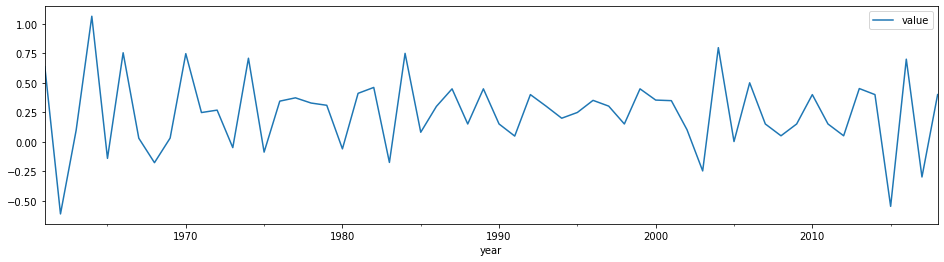

In [72]:
life_df1.plot()

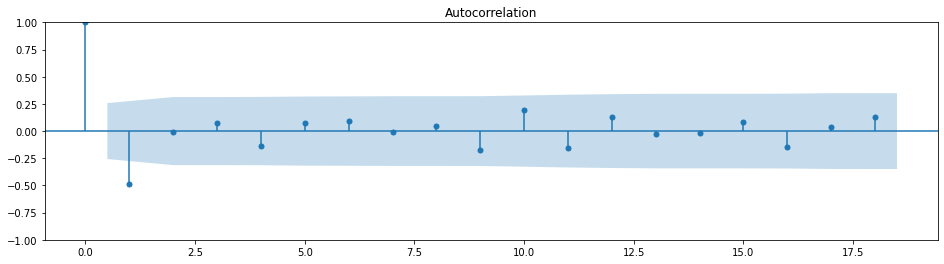

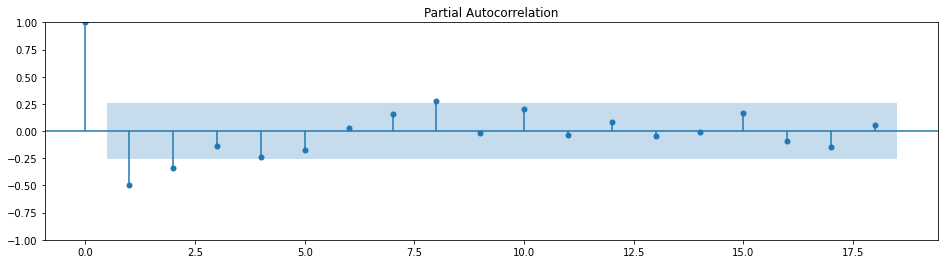

In [73]:
plot_acf(life.diff(1).dropna())
plot_pacf(life.diff(1).dropna()); plt.show()

In [23]:
acorr_ljungbox(life_df1, lags=10, return_df=True)

,lb_stat,lb_pvalue
1,14.613802,0.000132
2,14.616300,0.000670
3,14.998073,0.001818
4,16.165342,0.002805
5,16.494756,0.005565
6,17.019904,0.009210
7,17.030067,0.017203
8,17.163546,0.028450
9,19.406510,0.021950
10,22.035237,0.014926


In [88]:
model = ARIMA(life_train, order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -13.713
Date:                Wed, 12 Jan 2022   AIC                             33.426
Time:                        23:40:09   BIC                             39.101
Sample:                    01-01-1960   HQIC                            35.579
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.023     42.715      0.000       0.954       1.046
ma.L1         -0.9962      4.072     -0.245      0.807      -8.978       6.986
sigma2         0.0957      0.385      0.248      0.804      -0.659       0.851
===================================================================================
Ljung-Box (L1) (Q):                  10.36   Jarque-Bera (JB):                 2.08
Prob(Q):                              0.00   Prob(JB):                         0.35
Heteroskedasticity (H):               0.28   Skew:                             0.39
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [89]:
(acorr_ljungbox(results.resid, 
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()

0

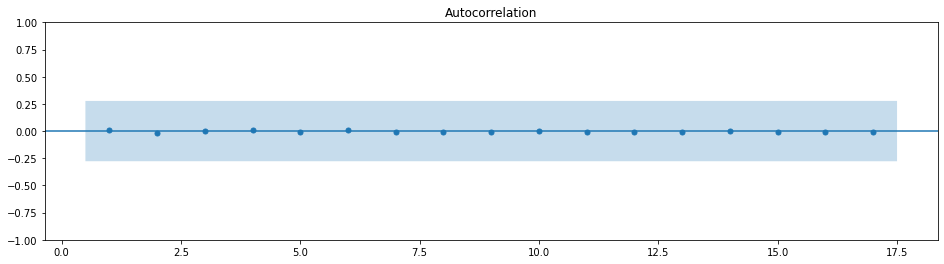

In [90]:
plot_acf(results.resid, zero=False);plt.show()

In [91]:
# from statsmodels.graphics.gofplots import qqplot

# pd.Series(results.resid).plot(kind='kde');plt.show()
# qqplot(results.resid, line='s'); plt.show()

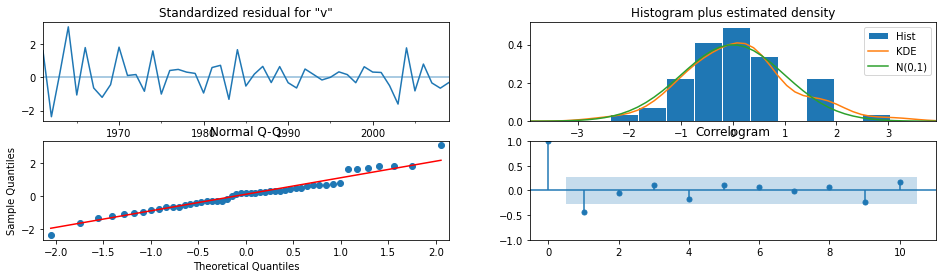

In [92]:
results.plot_diagnostics();plt.show()

In [93]:
(acorr_ljungbox(results.resid, 
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()

0

In [94]:
from scipy.stats import shapiro
shapiro(results.resid)[1] < 0.05

True

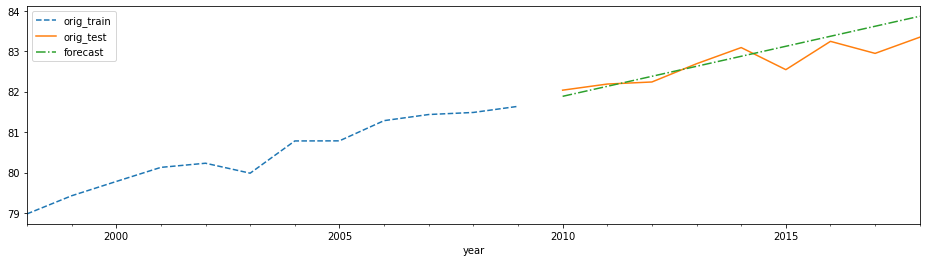

In [95]:
plot_forecast(results, '1998', life_train, life_test)

### There is more

In [97]:
pv, dv, qv = [list(range(3))]*3
vals = combinator([pv, dv, qv])
score = {}
for i, (p, d, q) in enumerate(vals):
    m = ARIMA(life_train, order=(p,d,q))
    res = m.fit()
    y = life_test.values.ravel() 
    y_hat = res.forecast(steps=len(y))
    score[i] = {'order': (p,d,q),
                'AIC':res.aic, 
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}

In [98]:
get_best_model(score, 'MAPE')

Best model: 13 with lowest MAPE score: 0.003382202015505773


In [99]:
best_m = get_best_model(score, 'AIC')

Best model: 8 with lowest AIC score: 7.69747092367904


In [111]:
score[4]

{'order': (0, 1, 1),
 'AIC': 52.321114838334836,
 'RMSPE': 0.13827179860055958,
 'RMSE': 1.1480576311744661,
 'MAPE': 0.012713339202463852,
 'model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x7fafef432bb0>}

In [101]:
score[8]

{'order': (0, 2, 2),
 'AIC': 7.69747092367904,
 'RMSPE': 0.05595582928461146,
 'RMSE': 0.4635773476233591,
 'MAPE': 0.004494177136593728,
 'model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x7faff0f1c9d0>}

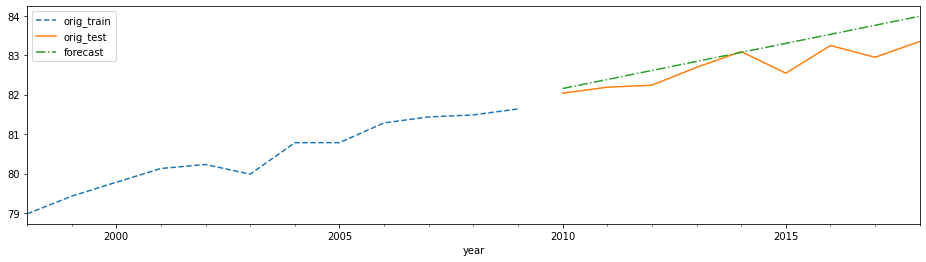

In [102]:
plot_forecast(best_m, '1998', life_train, life_test)

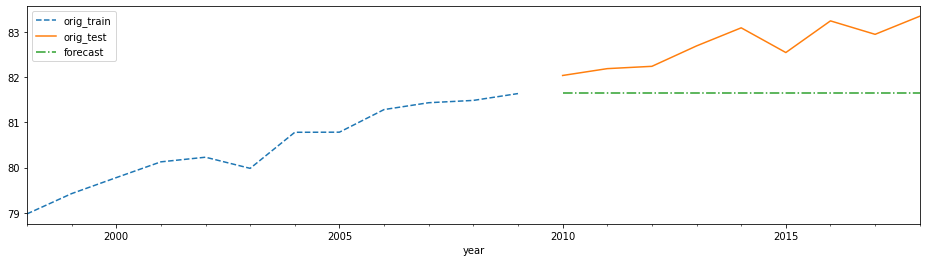

In [112]:
plot_forecast(score[4]['model'], '1998', life_train, life_test)

# Forecasting Univariate Time Series Data with Seasonal ARIMA

In [37]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

<AxesSubplot:xlabel='month'>

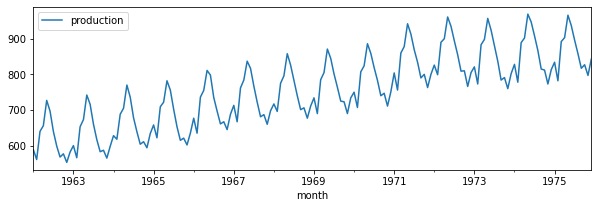

In [38]:
milk.plot()

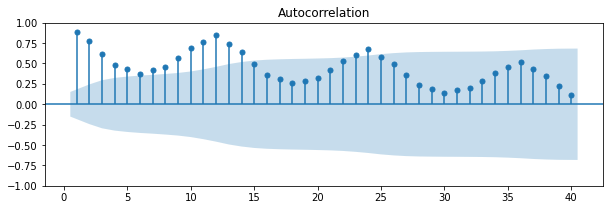

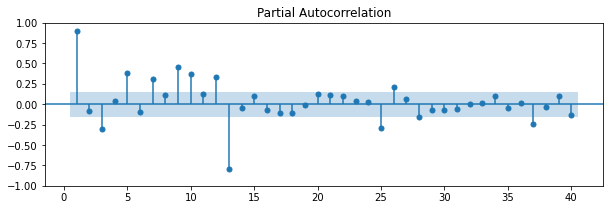

In [39]:
plot_acf(milk, lags=40, zero=False)
plot_pacf(milk, lags=40, zero=False);plt.show()

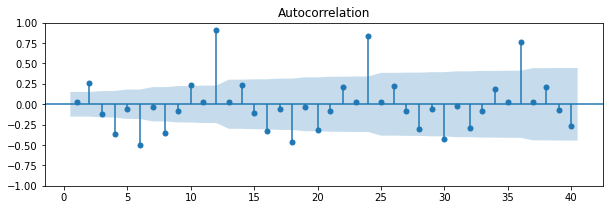

In [65]:
plot_acf(milk.diff(1).dropna(), lags=40, zero=False); plt.show()

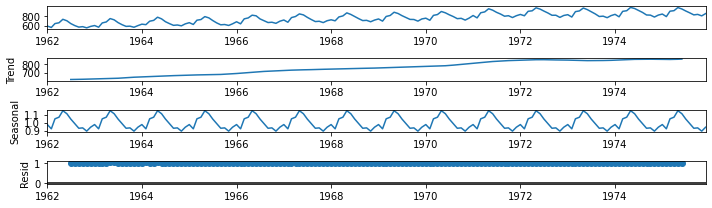

In [40]:
decomposed = seasonal_decompose(milk, period=12, model='multiplicative')
decomposed.plot(); plt.show()

In [42]:
milk_s = decomposed.seasonal

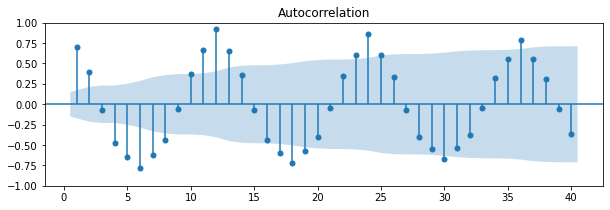

In [44]:
plot_acf(milk_s, zero=False, lags=40);plt.show()

In [45]:
milk_dif_1 = milk.diff(1).dropna()
milk_dif_12 = milk.diff(12).dropna()
milk_dif_12_1 = milk.diff(12).diff(1).dropna()

In [70]:
# fig, ax = plt.subplots(1, 4)
# milk.plot(ax= ax[0], title='original data', figsize=(20, 2))
# pd.Series(milk.mean().values.tolist()*n, index=idx).plot(ax=ax[0])
# milk_dif_1.plot(ax= ax[1], title='diff(1) detrending')
# pd.Series(milk_dif_1.mean().values.tolist()*n, index=idx).plot(ax=ax[1])
# milk_dif_12.plot(ax= ax[2], title='diff(12) deseasonalize')
# pd.Series(milk_dif_12.mean().values.tolist()*n, index=idx).plot(ax=ax[2])
# milk_dif_12_1.plot(ax= ax[3], title='diff(12).diff(1) twice differencing')
# pd.Series(milk_dif_12_1.mean().values.tolist()*n, index=idx).plot(ax=ax[3])

'c'	 Non-Stationary	 p-value:0.6274267086030316 	 lags:13
'c'	 Stationary	 p-value:0.030068004001785647 	 lags:14
'c'	 Non-Stationary	 p-value:0.1607988052771135 	 lags:12
'c'	 Stationary	 p-value:1.8654234318788342e-05 	 lags:11


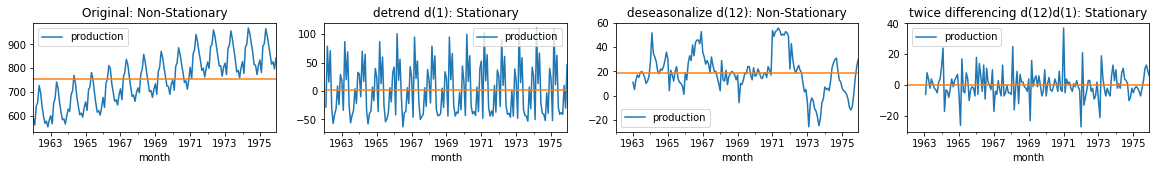

In [46]:
fig, ax = plt.subplots(1, 4)
sets = [milk, milk_dif_1, milk_dif_12, milk_dif_12_1]
desc = ['Original', 'detrend d(1)', 'deseasonalize d(12)', 'twice differencing d(12)d(1)']
index, n = milk.index, milk.shape[0]
for i, (d_set, d_desc) in enumerate(zip(sets, desc)):
    outcome, pval = check_stationarity(d_set)
    d_set.plot(ax= ax[i], title=f'{d_desc}: {outcome}', figsize=(20, 2))
    pd.Series(d_set.mean().values.tolist()*n, index=index).plot(ax=ax[i])

## Determine AR and MA terms

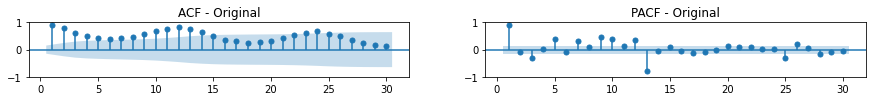

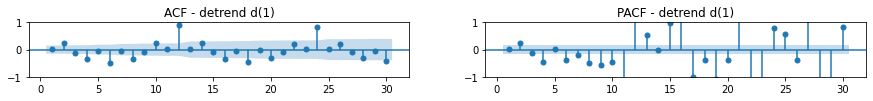

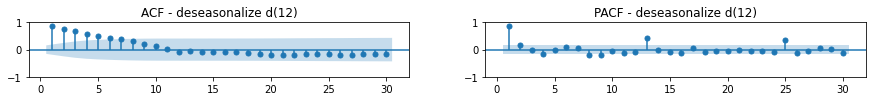

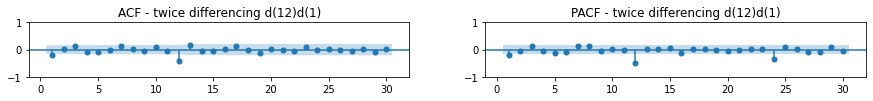

In [47]:
# `ARIMA(2,0,0)(0,1,1)[12]`
for i, (d_set, d_desc) in enumerate(zip(sets, desc)):
    fig, ax = plt.subplots(1,2, figsize=(15,1))
    for j in range(len(ax)):
        plot_acf(d_set, zero=False, lags=30, ax=ax[0], title=f'ACF - {d_desc}')
        plot_pacf(d_set, zero=False, lags=30, ax=ax[1], title=f'PACF - {d_desc}');plt.show()

[1, 12, 24, 36, 48]


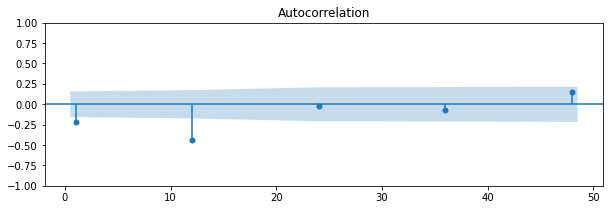

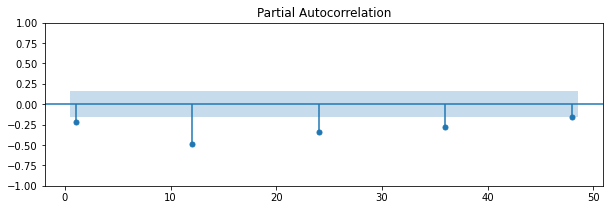

In [48]:
#lags = [1, 12, 24, 36, 48]
lags = [i for i in range(12, 60, 12)]
lags.insert(0, 1)
print(lags)
plot_acf(milk.diff(12).diff(1).dropna(),zero=False, lags=lags)
plot_pacf(milk.diff(12).diff(1).dropna(),zero=False, lags=lags);

## Fitting a SARIMA Model

In [60]:
sarima_model = SARIMAX(milk_train, 
                       order=(1,1,0),
                       seasonal_order=(0,1,2,12))
model = sarima_model.fit(disp=0)

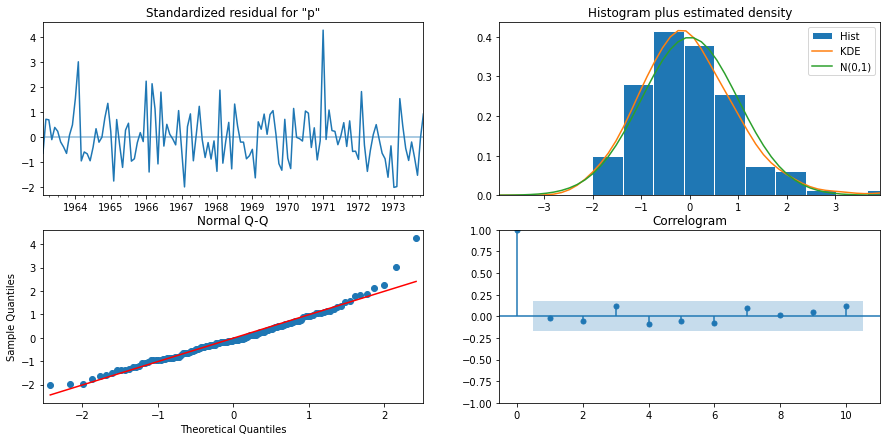

In [61]:
model.plot_diagnostics(figsize=(15,7)); plt.show()

In [62]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                              production   No. Observations:                  143
Model:             SARIMAX(1, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood                -448.906
Date:                                 Thu, 23 Dec 2021   AIC                            905.812
Time:                                         18:21:12   BIC                            917.283
Sample:                                     01-01-1962   HQIC                           910.473
                                          - 11-01-1973                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2704      0.090     -3.002      0.003      -0.447      -0.094
ma.S.L12      -0.6561      0.091     -7.192      0.000      -0.835      -0.477
ma.S.L24       0.0373      0.083      0.450      0.653      -0.125       0.200
sigma2        55.7258      5.711      9.757      0.000      44.531      66.920
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                36.87
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.83
Prob(H) (two-sided):                  0.67   Kurtosis:                         5.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='month'>

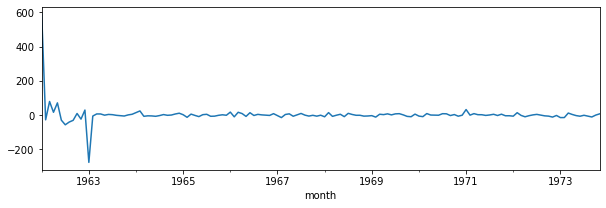

In [52]:
model.resid.plot()

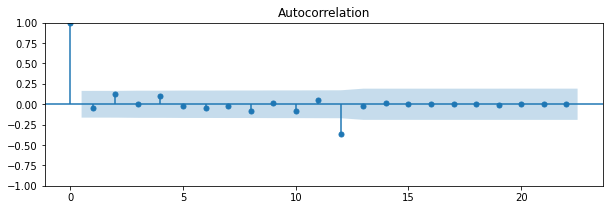

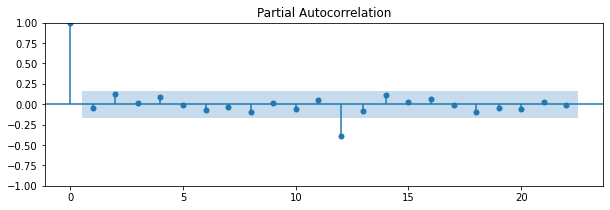

In [53]:
plot_acf(model.resid)
plot_pacf(model.resid); plt.show()

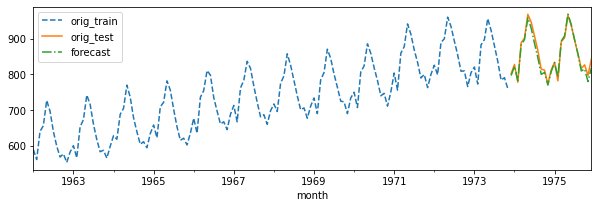

In [122]:
plot_forecast(model, '1962', milk_train, milk_test)

<AxesSubplot:xlabel='month'>

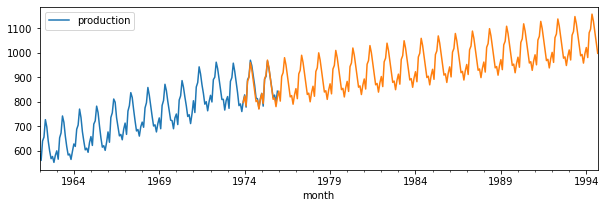

In [55]:
milk.plot()
model.forecast(steps=n*10).plot(style='-')

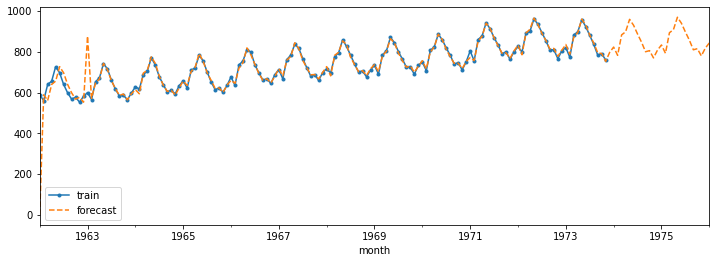

In [56]:
n = milk.shape[0]
milk_train.plot(style='.-', figsize=(12,4))
model.predict(end=n).plot(style='--')
plt.legend(['train', 'forecast'])

### There is more

In [114]:
P_ns, D_ns, Q_ns = [list(range(3))]*3
P_s, D_s, Q_s = [list(range(2))]*3

vals = combinator([P_ns, D_ns, Q_ns, P_s, D_s, Q_s])
score = {}
for i, (p, d, q, P, D, Q) in enumerate(vals):
    if i%15 == 0:
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},12)')
    m = SARIMAX(milk_train, 
                order=(p,d,q),
                seasonal_order=(P, D, Q, 12),
                enforce_stationarity=False)
    res = m.fit(disp=0)
    y = milk_test.values.ravel() 
    y_hat = res.forecast(steps=len(y))
    score[i] = {'non-seasonal order': (p,d,q),
                'seasona order': (P, D, Q),
                'AIC':res.aic, 
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}

Running model #0 using SARIMA(0,0,0)(0,0,0,12)
Running model #15 using SARIMA(0,0,1)(1,1,1,12)
Running model #30 using SARIMA(0,1,0)(1,1,0,12)
Running model #45 using SARIMA(0,1,2)(1,0,1,12)
Running model #60 using SARIMA(0,2,1)(1,0,0,12)
Running model #75 using SARIMA(1,0,0)(0,1,1,12)
Running model #90 using SARIMA(1,0,2)(0,1,0,12)
Running model #105 using SARIMA(1,1,1)(0,0,1,12)
Running model #120 using SARIMA(1,2,0)(0,0,0,12)
Running model #135 using SARIMA(1,2,1)(1,1,1,12)
Running model #150 using SARIMA(2,0,0)(1,1,0,12)
Running model #165 using SARIMA(2,0,2)(1,0,1,12)
Running model #180 using SARIMA(2,1,1)(1,0,0,12)
Running model #195 using SARIMA(2,2,0)(0,1,1,12)
Running model #210 using SARIMA(2,2,2)(0,1,0,12)


In [115]:
best_model = get_best_model(score, 'AIC')

Best model: 211 with lowest AIC score: 795.4217652895388


In [120]:
score[211]

{'non-seasonal order': (2, 2, 2),
 'seasona order': (0, 1, 1),
 'AIC': 795.4217652895388,
 'RMSPE': 0.17818982960206564,
 'RMSE': 15.135855599359052,
 'MAPE': 0.014454255464947679,
 'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7fd090ba9880>}

In [117]:
get_best_model(score, 'RMSE')

Best model: 191 with lowest RMSE score: 9.611047730620733


In [121]:
score[191]

{'non-seasonal order': (2, 1, 2),
 'seasona order': (1, 1, 1),
 'AIC': 797.0327719467928,
 'RMSPE': 0.11184327151550633,
 'RMSE': 9.611047730620733,
 'MAPE': 0.009043262112792728,
 'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7fd0173e9e50>}

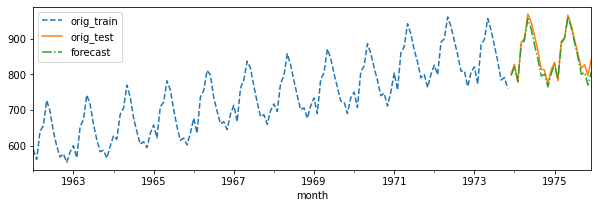

In [119]:
plot_forecast(best_model, '1962', milk_train, milk_test)

# Forecasting Time Series Data using Auto_ARIMA

In [123]:
import pmdarima as pm

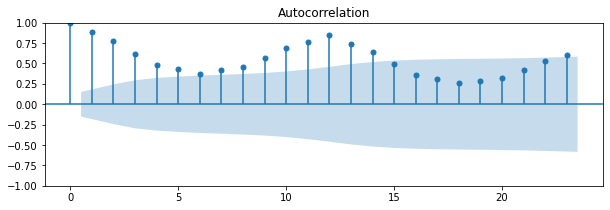

In [125]:
pm.plot_acf(milk, alpha=0.05)

In [128]:
auto_model = pm.auto_arima(milk_train, 
                           seasonal=True, 
                           m=12, 
                           test='adf',
                          stepwise=True)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  143
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -448.668
Date:                            Thu, 23 Dec 2021   AIC                            903.335
Time:                                    19:43:52   BIC                            911.938
Sample:                                         0   HQIC                           906.831
                                            - 143                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2811      0.084     -3.331      0.001      -0.446      -0.116
ma.S.L12      -0.6334      0.083     -7.653      0.000      -0.796      -0.471
sigma2        55.5239      5.753      9.650      0.000      44.247      66.800
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.77
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.82
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [129]:
pm.auto_arima(life_train)

ARIMA(order=(5, 1, 0), scoring_args={}, suppress_warnings=True)

In [83]:
auto_model = pm.auto_arima(milk_train, seasonal=True, m=12, test='adf', trace=True)
auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=908.834, Time=0.53 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=951.320, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=917.481, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=903.335, Time=0.11 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=940.547, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=905.280, Time=0.13 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=905.265, Time=0.26 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=917.295, Time=0.06 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.35 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=911.816, Time=0.06 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=905.240, Time=0.14 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=905.159, Time=0.16 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=903.959, Time=0.11 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=907.070, Time=0.39 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  143
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -448.668
Date:                            Wed, 22 Dec 2021   AIC                            903.335
Time:                                    21:33:41   BIC                            911.938
Sample:                                         0   HQIC                           906.831
                                            - 143                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2811      0.084     -3.331      0.001      -0.446      -0.116
ma.S.L12      -0.6334      0.083     -7.653      0.000      -0.796      -0.471
sigma2        55.5239      5.753      9.650      0.000      44.247      66.800
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.77
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.82
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

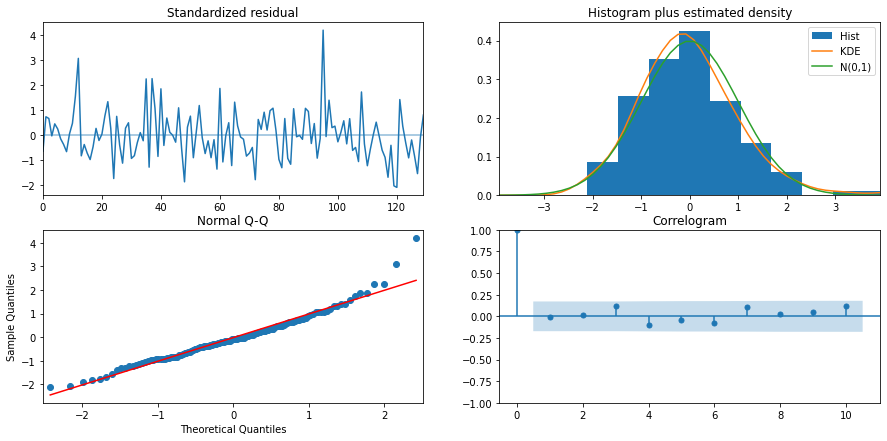

In [143]:
auto_model.plot_diagnostics(figsize=(15,7)); plt.show()

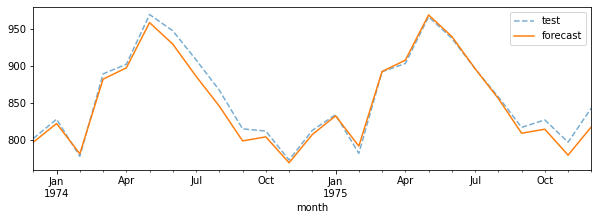

In [159]:
n = milk_test.shape[0]
index = milk_test.index
milk_test.plot(style='--', alpha=0.6)
pd.Series(auto_model.predict(n_periods=n), 
          index=index).plot(style='-')
plt.legend(['test', 'forecast']); plt.show()

In [160]:
n = milk_test.shape[0]
mape_m = mape(milk_test, model.forecast(n))
mape_auto = mape(milk_test, auto_model.predict(n))
rmse_m = rmse(milk_test.values.ravel(), model.forecast(n))
rmse_auto = rmse(milk_test.values.ravel(), auto_model.predict(n))
print(f'''
MAPE: manual = {mape_m}, auto = {mape_auto}
RMSE: manual = {rmse_m}, auto = {rmse_auto}
AIC : manual = {model.aic}, auto = {auto_model.aic()}
''')


MAPE: manual = 0.009772045332709214, auto = 0.01021795438486209
RMSE: manual = 10.769106417147581, auto = 11.318041156802128
AIC : manual = 905.8123849904084, auto = 903.3352377587078



### There is more

In [161]:
from pmdarima.arima.stationarity import ADFTest, KPSSTest, PPTest

adf_test, kpss_test, pp_test = ADFTest(), KPSSTest(), PPTest()

In [163]:
milk_dif_1 = milk.diff(1).dropna()

print(adf_test.should_diff(milk_dif_1))
print(kpss_test.should_diff(milk_dif_1))
print(pp_test.should_diff(milk_dif_1))

(0.01, False)
(0.1, False)
(0.01, False)


In [164]:
from pmdarima.arima.utils import ndiffs, nsdiffs

# ADF test:
n_adf = ndiffs(milk, test='adf') 
# KPSS test (auto_arima default):
n_kpss = ndiffs(milk, test='kpss') 
# PP test:
n_pp = ndiffs(milk, test='pp')  

In [165]:
print(n_adf, n_kpss, n_pp)

0 1 0


In [166]:
# Canova-Hansen test
n_ch = nsdiffs(milk, test='ocsb', m=10, max_D=1) 
# OCSB test
n_ocsb = nsdiffs(milk, test='ch' , m=10, max_D=12,) 


In [167]:
print(n_ch, n_ocsb)

0 0


In [95]:
model = pm.auto_arima(milk, 
                      d=1,
                      start_p=0, max_p=2,
                      start_q=0, max_q=2,
                      seasonal=True,
                      m=12,
                      D=1,
                      start_P=0, max_P=2,
                      start_Q=0, max_Q=2,
                      information_criterion='aic',
                      stepwise=False,
                      out_of_sample_siz=25,
                      score='mse',
                      trace=True)
                    

print(model.summary())

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1119.969, Time=0.01 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1072.280, Time=0.08 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1074.086, Time=0.27 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1089.113, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1074.131, Time=0.09 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.18 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1080.886, Time=0.14 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=1075.400, Time=0.35 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.26 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1114.995, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1066.296, Time=0.10 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1067.976, Time=0.28 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1082.123, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1068.030, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.96 sec
 ARIMA(0,1

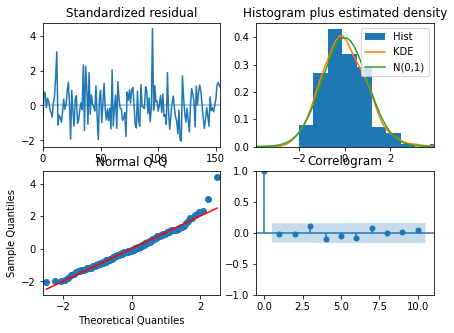

In [96]:
model.plot_diagnostics(figsize=(7,5));

# Forecasting Multivariate Time Series Data using VAR

In [168]:
import pandas_datareader.data as web
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

In [169]:
start = "01-01-1980"
end = "09-30-2021"

fedfund_df = web.FredReader(symbols=["FEDFUNDS"], 
                            start=start, end=end).read()
cpi_df = web.FredReader(symbols=["CPALTT01USM657N"], 
                        start=start, end=end).read()
unemp_df = web.FredReader(symbols=["unrate"], 
                          start=start, end=end).read()

In [170]:
fedfund_df.head()

,FEDFUNDS
DATE,
1980-01-01,13.82
1980-02-01,14.13
1980-03-01,17.19
1980-04-01,17.61
1980-05-01,10.98


In [171]:
fedfund_df.shape

(501, 1)

In [172]:
# unemp_df = unemp_df.resample('QS').first()
unemp_df.head()

,unrate
DATE,
1980-01-01,6.3
1980-02-01,6.3
1980-03-01,6.3
1980-04-01,6.9
1980-05-01,7.5


In [173]:
unemp_df.shape

(501, 1)

In [174]:
cpi_df.head()

,CPALTT01USM657N
DATE,
1980-01-01,1.434159
1980-02-01,1.413882
1980-03-01,1.520913
1980-04-01,1.123596
1980-05-01,0.987654


In [105]:
cpi_df.shape

(501, 1)

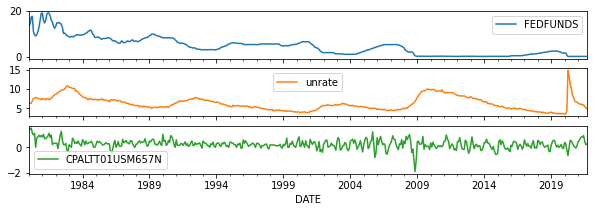

In [175]:
df_mul = pd.concat([fedfund_df, unemp_df, cpi_df], join='inner', axis=1)
df_mul.plot(subplots=True); plt.show()

In [181]:
df_mul_scaled = df_mul.copy()
for column in df_mul_scaled.columns:
    d = df_mul_scaled[column]
    df_mul_scaled[column] = ((d - d.min()) / (d.max() - d.min()))

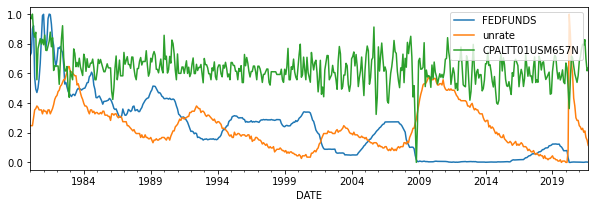

In [184]:
df_mul_scaled.plot(); plt.show()

In [185]:
check_stationarity(df_mul_scaled['FEDFUNDS'])
check_stationarity(df_mul_scaled['unrate'])
check_stationarity(df_mul_scaled['CPALTT01USM657N'])

'c'	 Stationary	 p-value:0.00010565171095316011 	 lags:16
'c'	 Stationary	 p-value:0.02450232311267524 	 lags:2
'c'	 Stationary	 p-value:3.9176569302120175e-05 	 lags:12


('Stationary', 3.9176569302120175e-05)

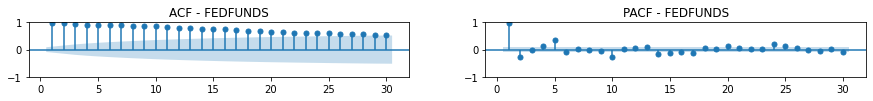

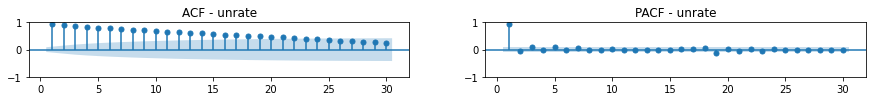

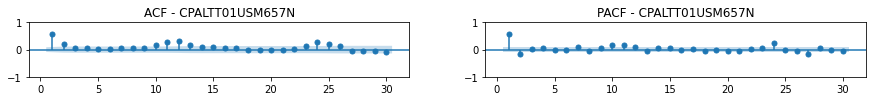

In [186]:
for col in df_mul_scaled.columns:
    fig, ax = plt.subplots(1,2, figsize=(15,1))
    plot_acf(df_mul_scaled[col], zero=False, 
             lags=30, ax=ax[0], title=f'ACF - {col}')
    plot_pacf(df_mul_scaled[col], zero=False, 
              lags=30, ax=ax[1], title=f'PACF - {col}');plt.show()

In [111]:
# gc_res = grangercausalitytests(df_mul_st, 5)

In [187]:
test_split = 0.20
train, test = split_data(df_mul_scaled, test_split)

train: 401 , test: 100


In [188]:
model = VAR(endog=train)
res = model.select_order(20, trend="c")
res.summary()

,AIC,BIC,FPE,HQIC
0,-12.06,-12.03,5.798e-06,-12.05
1,-21.64,-21.51,4.015e-10,-21.59
2,-21.98,-21.76*,2.857e-10,-21.89
3,-21.99,-21.68,2.828e-10,-21.86
4,-22.03,-21.63,2.695e-10,-21.87
5,-22.10,-21.60,2.530e-10,-21.90*
6,-22.12,-21.53,2.486e-10,-21.88
7,-22.11,-21.43,2.497e-10,-21.84
8,-22.12,-21.35,2.467e-10,-21.82
9,-22.12,-21.25,2.483e-10,-21.77


In [189]:
print(f'AIC: {res.aic} , BIC: {res.bic}, HQ: {res.hqic}, FPE: {res.fpe}')

AIC: 14 , BIC: 2, HQ: 5, FPE: 14


In [190]:
results = model.fit(maxlags=14, ic='aic')

In [191]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 23, Dec, 2021
Time:                     20:56:22
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -20.6681
Nobs:                     387.000    HQIC:                  -21.4643
Log likelihood:           2736.20    FPE:                2.83227e-10
AIC:                     -21.9875    Det(Omega_mle):     2.06472e-10
--------------------------------------------------------------------
Results for equation FEDFUNDS
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.005750         0.017729            0.324           0.746
L1.FEDFUNDS                 1.436153         0.051297           27.997           0.000
L1.unrate                  -0.136

In [117]:
results.params

,FEDFUNDS,unrate,CPALTT01USM657N
const,-0.004781,0.000079,-0.017062
L1.FEDFUNDS,1.436153,-0.103817,1.675408
L1.unrate,-0.099621,0.938557,-0.035573
L1.CPALTT01USM657N,-0.006023,0.001464,0.472408
L2.FEDFUNDS,-0.498854,0.079408,-1.889325
L2.unrate,0.070721,0.105638,-0.512281
L2.CPALTT01USM657N,-0.001151,0.002522,-0.190410
L3.FEDFUNDS,0.121622,-0.128791,-0.077964
L3.unrate,-0.021961,0.112766,-0.519136
L3.CPALTT01USM657N,-0.003108,-0.001423,-0.098243


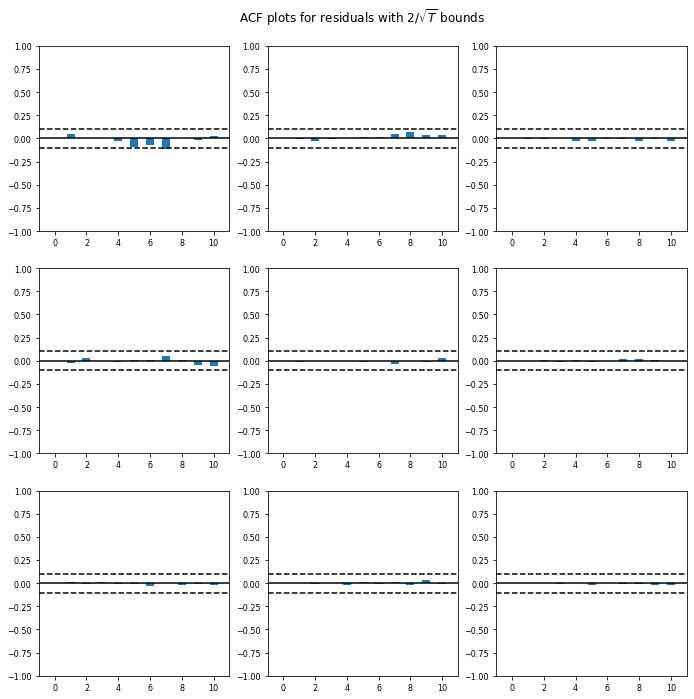

In [192]:
results.plot_acorr();

In [193]:
lag_order = results.k_ar
lag_order

14

In [194]:
n = test.shape[0]
forecast = results.forecast(df_mul.values[-lag_order:], n)

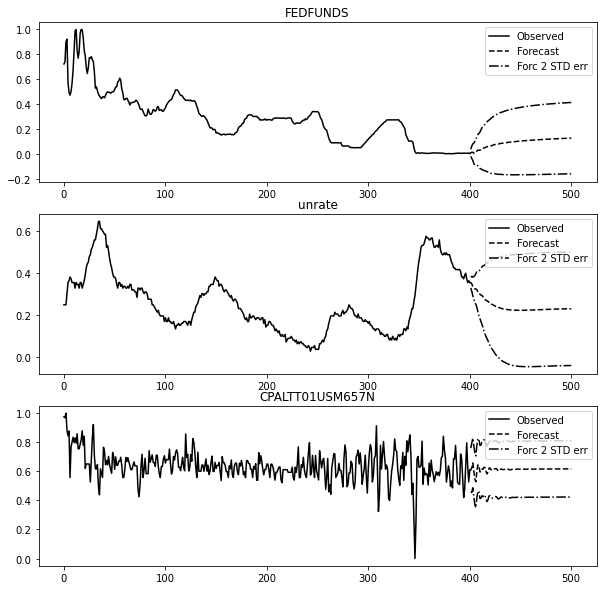

In [195]:
results.plot_forecast(n);

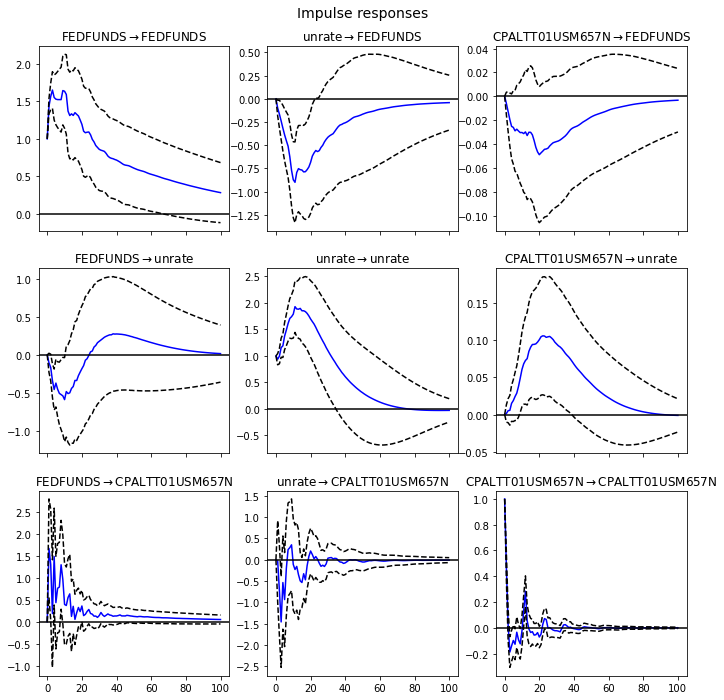

In [122]:
irf = results.irf(n)
irf.plot(orth=False);plt.show()

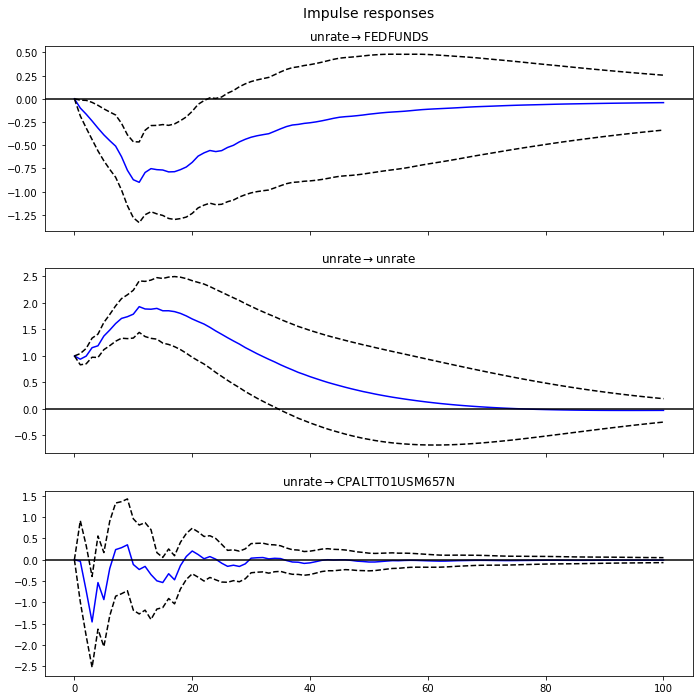

In [123]:
irf.plot(impulse='unrate');plt.show()

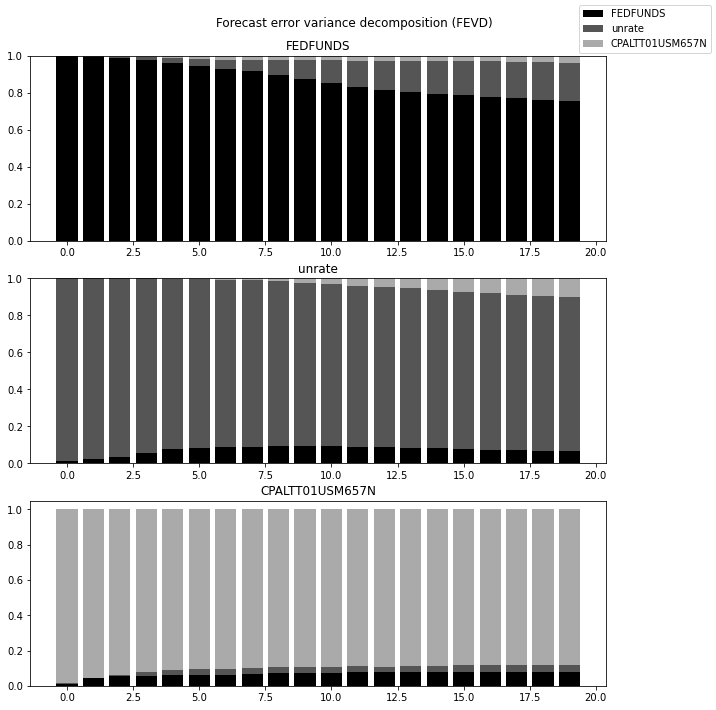

In [196]:
results.fevd(20).plot();plt.show()

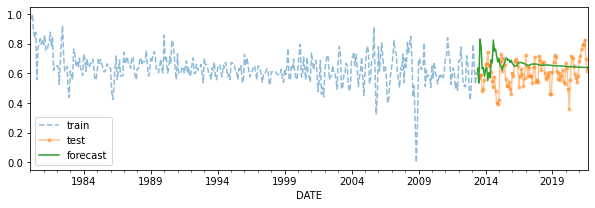

In [197]:
train['CPALTT01USM657N'].plot(style='--',alpha=0.5)
test['CPALTT01USM657N'].plot(style='.-', alpha=0.45)
pd.Series(forecast[ :, 2], index=test.index).plot()
plt.legend(['train', 'test', 'forecast'])

### There is more

In [249]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [250]:
res = coint_johansen(df_mul_st, -1, 5)

In [251]:
res.lr1

array([1.06803856e+01, 4.92500563e-04])

In [252]:
res.cvt

array([[10.4741, 12.3212, 16.364 ],
       [ 2.9762,  4.1296,  6.9406]])

# Forecasting Time Series Data using Prophet

In [126]:
from prophet import Prophet

In [127]:
milk_p = milk.reset_index()
msft_p = msft.reset_index()
life_p = life.reset_index()

In [128]:
cols = ['ds', 'y']
milk_p.columns = cols
msft_p.columns = cols
life_p.columns = cols

In [129]:
test_split = 0.15
train_milk, test_milk = split_data(milk_p, test_split)
train_msft, test_msft = split_data(msft_p, test_split)
train_life, test_life = split_data(life_p, test_split)

train: 143 , test: 25
train: 2354 , test: 415
train: 50 , test: 9


In [130]:
m_milk = Prophet(seasonality_mode='multiplicative').fit(train_milk)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.63781
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       562.843     0.0483286       651.484           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     171       566.489   0.000142385        111.47   1.637e-06       0.001      253  LS failed, Hessian reset 
     199       566.761   0.000476663       82.0237           1           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     294       568.034   0.000281645       236.354   2.178e-06       0.001      450  LS failed, Hessian reset 
     299       568.124   0.000858039       210.683           1           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312       568.265   0.000143229       203.491   1.888e-06       0.001      501  LS failed, Hessian rese

In [131]:
m_msft = Prophet(daily_seasonality=True).fit(train_msft)

Initial log joint probability = -69.7468
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7804.31    0.00287564       1686.39           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7927.62    0.00243893       752.161           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7946.33   0.000824179       572.408           1           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7974.65     0.0153396       854.896           1           1      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7989.68     0.0234238       1263.15           1           1      591   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [132]:
m_life = Prophet(yearly_seasonality=True ).fit(train_life)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -60.1104
Iteration  1. Log joint probability =    158.805. Improved by 218.916.
Iteration  2. Log joint probability =    195.564. Improved by 36.7583.
Iteration  3. Log joint probability =    226.581. Improved by 31.0172.
Iteration  4. Log joint probability =     254.17. Improved by 27.5894.
Iteration  5. Log joint probability =    271.227. Improved by 17.0563.
Iteration  6. Log joint probability =    271.337. Improved by 0.110207.
Iteration  7. Log joint probability =    271.993. Improved by 0.656614.
Iteration  8. Log joint probability =    272.252. Improved by 0.25908.
Iteration  9. Log joint probability =    272.559. Improved by 0.306913.
Iteration 10. Log joint probability =    272.738. Improved by 0.17876.
Iteration 11. Log joint probability =    273.269. Improved by 0.531248.
Iteration 12. Log joint probability =    273.812. Improved by 0.542823.
Iteration 13. Log joint probability =    273.974. Improved by 0.162228.
Iteration 14. Log joint proba

In [133]:
print(f'''
{test_milk.shape}
{test_msft.shape}
{test_life.shape}
''')


(25, 2)
(415, 2)
(9, 2)



In [134]:
milk_future = m_milk.make_future_dataframe(25, freq='MS')
msft_future = m_msft.make_future_dataframe(415, freq='B')
life_future = m_life.make_future_dataframe(9, freq='AS')

In [135]:
train_milk.shape

(143, 2)

In [136]:
milk_future.shape

(168, 1)

In [137]:
forecast_milk = m_milk.predict(milk_future)
forecast_msft = m_msft.predict(msft_future)
forecast_life = m_life.predict(life_future)

In [138]:
forecast_life.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [139]:
forecast_msft.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [140]:
cols = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']

In [141]:
forecast_life[cols].tail()

,ds,yhat,yhat_lower,yhat_upper
54,2014-01-01,83.026051,82.781093,83.279912
55,2015-01-01,83.264176,83.014226,83.514227
56,2016-01-01,83.520437,83.274281,83.779890
57,2017-01-01,83.768923,83.501812,84.043652
58,2018-01-01,83.997388,83.714608,84.271816


In [142]:
forecast_milk[cols].tail()

,ds,yhat,yhat_lower,yhat_upper
163,1975-08-01,855.345470,840.110863,871.763668
164,1975-09-01,807.070057,790.743562,823.228117
165,1975-10-01,813.142784,796.096420,829.519488
166,1975-11-01,776.637810,760.800858,793.174656
167,1975-12-01,817.228013,799.711241,834.073239


In [143]:
forecast_msft[cols].tail()

,ds,yhat,yhat_lower,yhat_upper
2764,2020-12-07,161.073923,149.910616,173.088229
2765,2020-12-08,161.224597,149.865667,173.242569
2766,2020-12-09,161.239117,149.358320,173.073377
2767,2020-12-10,161.294447,150.126586,173.087068
2768,2020-12-11,161.378627,149.647236,173.602017


In [144]:
cols = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
data = [('Microsoft Stock Price',test_msft, m_msft), 
        ('Milk Production', test_milk, m_milk), 
        ('Life Expectancy', test_life, m_life)]

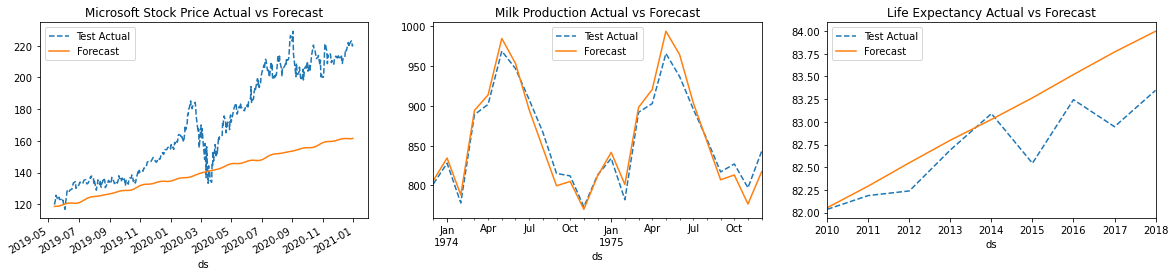

In [331]:
fig, ax = plt.subplots(1, 3, figsize=(20,4))
for i, (name, df, m) in enumerate(data):
    predicted = m.predict(df)[cols]
    df.plot(kind='line',x='ds', y='y', label='Test Actual', ax=ax[i], style='--')
    predicted.plot(kind='line',x='ds',y='yhat', label='Forecast', ax=ax[i])
    ax[i].title.set_text(f'{name} Test Actual vs Forecast')
plt.show()

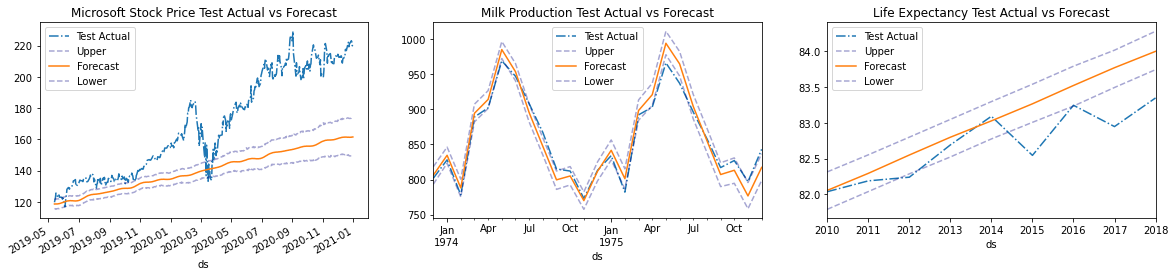

In [145]:
fig, ax = plt.subplots(1, 3, figsize=(20,4))
for i, (name, df, m) in enumerate(data):
    predicted = m.predict(df)[cols]
    df.plot(kind='line',x='ds', y='y', label='Test Actual', ax=ax[i], style='-.')
    predicted.plot(kind='line',x='ds',y='yhat_upper', label='Upper', ax=ax[i], color='navy', style='--', alpha=0.35)
    predicted.plot(kind='line',x='ds',y='yhat', label='Forecast', ax=ax[i])
    predicted.plot(kind='line',x='ds',y='yhat_lower', label='Lower', ax=ax[i], color='navy', style='--', alpha=0.35)
    ax[i].title.set_text(f'{name} Test Actual vs Forecast')
plt.show()

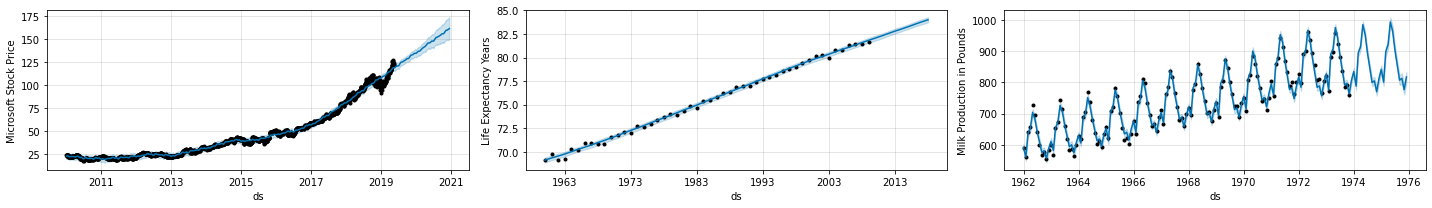

In [147]:
fig, ax = plt.subplots(1, 3, figsize=(20,3))
m_msft.plot(forecast_msft, ax=ax[0], ylabel='Microsoft Stock Price')
m_life.plot(forecast_life, ax=ax[1], ylabel='Life Expectancy Years')
m_milk.plot(forecast_milk, ax=ax[2], ylabel='Milk Production in Pounds')
plt.show()

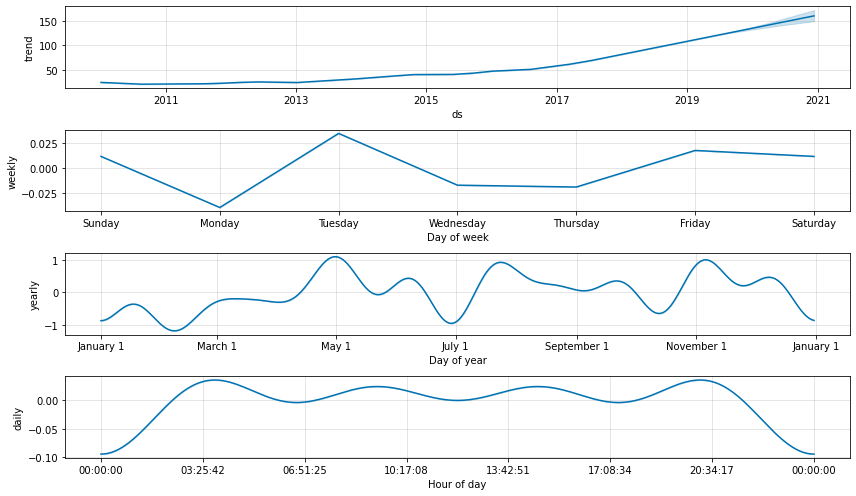

In [148]:
m_msft.plot_components(forecast_msft, figsize=(12,7)); plt.show()

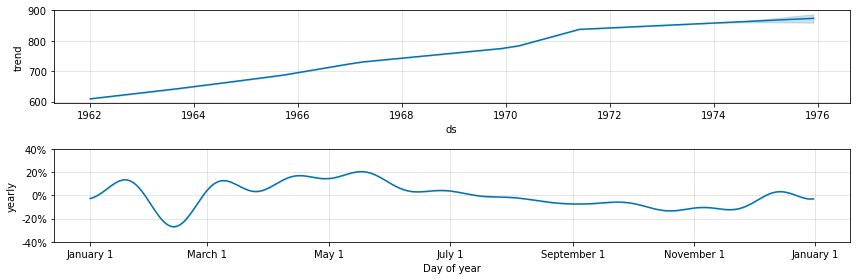

In [149]:
m_milk.plot_components(forecast_milk, figsize=(12,4)); plt.show()

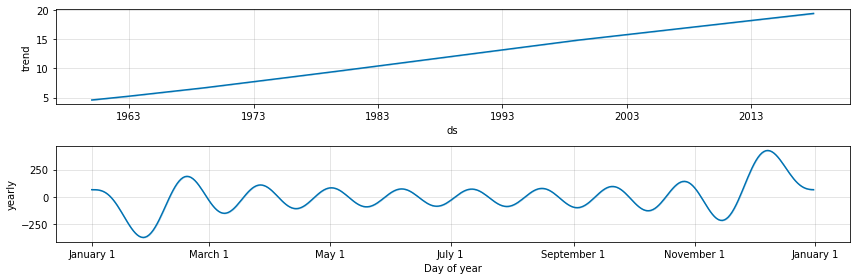

In [293]:
m_life.plot_components(forecast_life, figsize=(12,4)); plt.show()

# Forecasting Volatility in Financial Time Series Data with GARCH


In [349]:
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

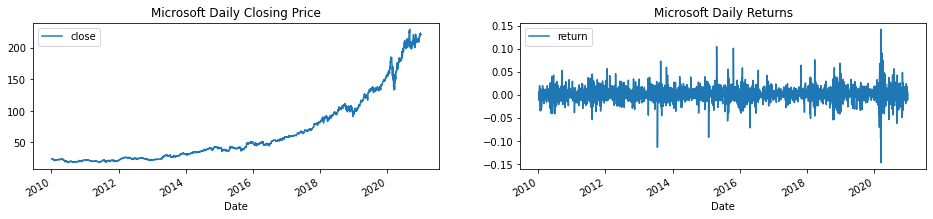

In [407]:
msft_return = msft.pct_change().dropna()
msft_return.columns = ['return']

fig, ax = plt.subplots(1,2, figsize=(16,3))
msft.plot(ax=ax[0])
msft_return.plot(ax=ax[1])
ax[0].title.set_text('Microsoft Daily Closing Price')
ax[1].title.set_text('Microsoft Daily Returns')


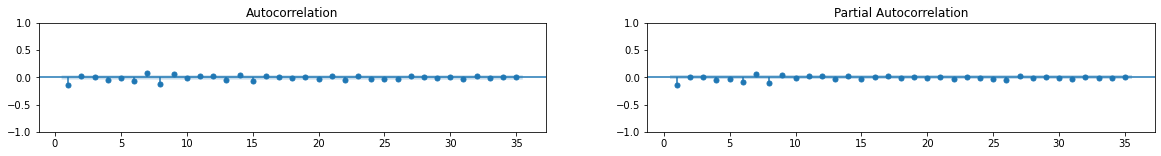

In [477]:
fig, ax = plt.subplots(1,2, figsize=(20,2))
plot_acf(msft_return, zero=False, ax=ax[0])
plot_pacf(msft_return, zero=False, ax=ax[1]); plt.show()

In [361]:
volatility = msft_return.std()
volatility

close    0.015993
dtype: float64

In [362]:
annualized = np.sqrt(252)*volatility
annualized

close    0.253888
dtype: float64

<AxesSubplot:xlabel='Date'>

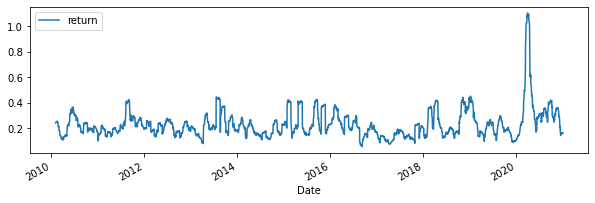

In [451]:
msft_return.rolling(22).apply(lambda x: x.std()*np.sqrt(252)).plot()

In [463]:
train, test = split_data(msft_return, 0.10)

train: 2491 , test: 277


In [464]:
msft_gm = arch_model(train).fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.0009688463452016e+20
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2630851955.044345
Iteration:      3,   Func. Count:     31,   Neg. LLF: 85543857193550.4
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7105.53750115863
            Iterations: 3
            Function evaluations: 41
            Gradient evaluations: 3


$\omega$, $\alpha$ and $\beta$ are estimated by Maximum Likelihood Method

In [465]:
msft_gm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                7105.54
Distribution:                  Normal   AIC:                          -14203.1
Method:            Maximum Likelihood   BIC:                          -14179.8
                                        No. Observations:                 2491
Date:                Tue, Dec 21 2021   Df Residuals:                     2490
Time:                        22:39:39   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.0947e-03  2.689e-04      4.071  4.672e-05 [5.677e-04,1.622e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.0636e-05  5.076e-12  4.066e+06      0.000 [2.064e-05,2.064e-05]
alpha[1]       0.1000  2.960e-02      3.378  7.294e-04   [4.198e-02,  0.158]
beta[1]        0.8000  2.868e-02     27.893 3.210e-171     [  0.744,  0.856]
============================================================================

Covariance estimator: robust
"""

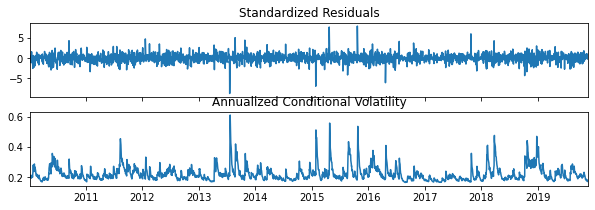

In [466]:
msft_gm.plot(annualize='D');

<AxesSubplot:>

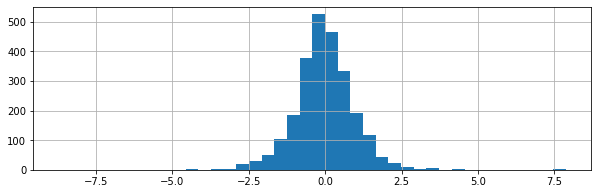

In [529]:
msft_gm.std_resid.hist(bins=40)

In [546]:
msft_vol_forecast = msft_gm.forecast(reindex=False)
print(msft_vol_forecast.variance)

                 h.1
Date                
2019-11-25  0.000121


In [552]:
msft_vol_forecast = msft_gm.forecast(horizon=test.shape[0], 
                                     reindpip install --upgrade tsmoothieex=False)
msft_vol_forecast.variance.shape

(1, 277)

In [561]:
melted_df = pd.melt(msft_vol_forecast.variance)
melted_df.index = test.index
print(melted_df.head())

           variable     value
Date                         
2019-11-26    h.001  0.000121
2019-11-27    h.002  0.000130
2019-11-29    h.003  0.000137
2019-12-02    h.004  0.000144
2019-12-03    h.005  0.000150


<AxesSubplot:xlabel='Date'>

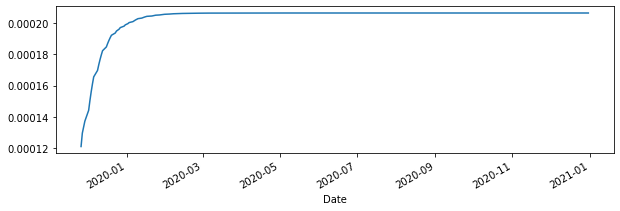

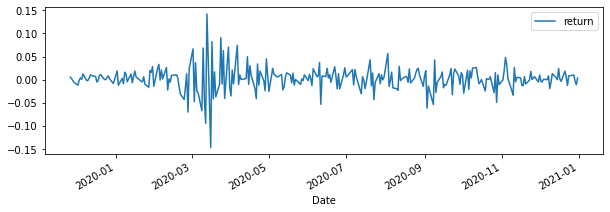

In [562]:
forecast = msft_vol_forecast.variance[-1:].values.ravel()
pd.Series(forecast, index=test.index).plot()
test.plot()

# Forecasting Time Series Data using Kalman Filter Algorithm

In [150]:
from darts import TimeSeries
from darts.models import KalmanFilter, FFT, ExponentialSmoothing, AutoARIMA

In [151]:
milk_model = ExponentialSmoothing(seasonal_periods=12)
milk_ts = TimeSeries.from_dataframe(milk.reset_index(), 
                                    time_col='month', value_cols='production', freq='MS')

In [152]:
p = 0.15
milk_train, milk_test = split_data(milk_ts.diff(), p)

train: 142 , test: 25


In [153]:
milk_model.fit(milk_train)
milk_pred = milk_model.predict(len(milk_test), num_samples=1000)

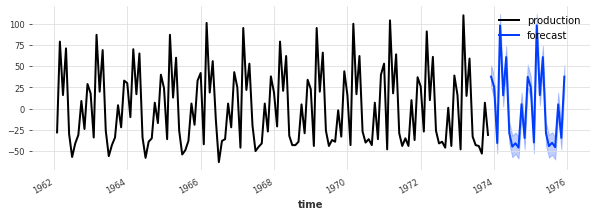

In [154]:
milk_train.plot()
milk_pred.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)

In [155]:
milk_filtered = KalmanFilter().filter(milk_ts.diff())
milk_model_filtered = ExponentialSmoothing(seasonal_periods=12)

p = 0.15
milk_train_filtered, milk_test_filtered = split_data(milk_filtered, p)

train: 142 , test: 25


In [156]:
milk_model_filtered.fit(milk_train_filtered)
milk_pred_filtered = milk_model_filtered.predict(len(milk_test), num_samples=1000)

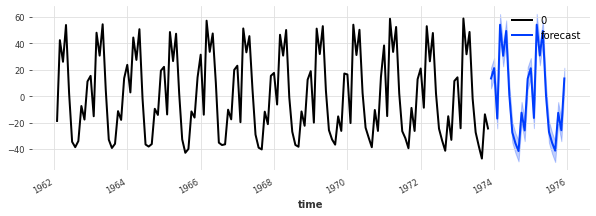

In [157]:
milk_train_filtered.plot()
milk_pred_filtered.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)

# Forecasting Time Series with Multiple Seasonal Components using TBATS

In [13]:
from sktime.forecasting.tbats import TBATS

In [14]:
web = Path('../../datasets/Ch9/web_traffic.csv')
weather = Path('../../datasets/Ch9/weather.csv')
elec = Path('../../datasets/Ch9/vic_elec.csv')

In [15]:
electdemand = pd.read_csv(elec, 
                          index_col='Time', 
                          parse_dates=True,
                         usecols=['Time', 'Demand', 'Temperature'])

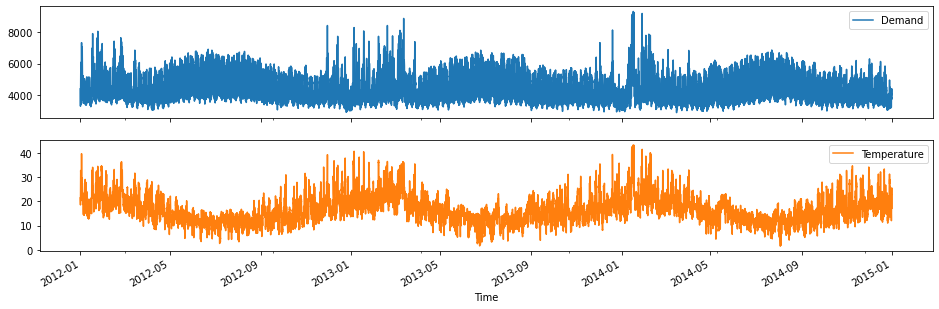

In [16]:
electdemand.plot(subplots=True,figsize=(16, 5)); plt.show()

In [17]:
elect2014 = electdemand['Demand'].loc['2014':]

In [21]:
elect2014 = elect2014.sort_index()

In [45]:
train, test = split_data(elect2014, 0.75)

train: 4380 , test: 13140


In [23]:
model = TBATS(sp=[14, 30.5], n_jobs=1, use_box_cox=False, use_trend=False, use_damped_trend=False)

In [46]:
model = TBATS()

In [47]:
model.fit(train)

TBATS(box_cox_bounds=(0, 1), context=None, multiprocessing_start_method='spawn',
      n_jobs=None, show_warnings=True, sp=None, use_arma_errors=True,
      use_box_cox=None, use_damped_trend=None, use_trend=None)

In [52]:
model.predict(fh=[1,2,3])

ValueError: Must supply freq for datetime value

In [39]:
test.index[0:3].values.tolist()

[1407452400000000000, 1407454200000000000, 1407456000000000000]

In [48]:
model.check_is_fitted()

In [49]:
model.get_fitted_params()

{'a': None, 'i': None, 'c': None}

In [50]:
model.get_test_params()

ModuleNotFoundError: No module named 'pyod'